In [18]:
import torch
import cv2
import matplotlib.pyplot as plt
from training.data.dataset import TrainingDataset
from training.model.model_definition import UNet
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

img_path1 = r"training\data\training_data\v4\22.png"
img_path2 = r"training\data\training_data\v4\20.png"

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)

img1_b = TrainingDataset().make_black(img1)
img2_b = TrainingDataset().make_black(img2)

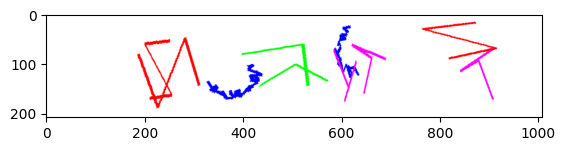

In [19]:
plt.imshow(img1)

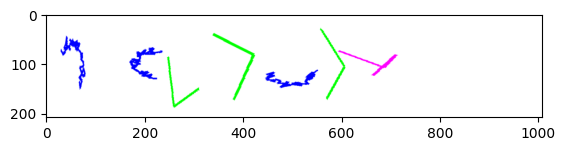

In [20]:
plt.imshow(img2)

In [21]:
model_path = r"training\model\models\transfer_v5.pth"
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=4
    )
model.load_state_dict(torch.load(model_path))
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

img1_t = transform(img1_b).unsqueeze(0) # unsqueeze to add a batch dimension to tensor
img2_t = transform(img2_b).unsqueeze(0)

In [22]:
img1_p = model(img1_t)
img2_p = model(img2_t)

In [23]:
img1_p.shape

torch.Size([1, 4, 208, 1008])

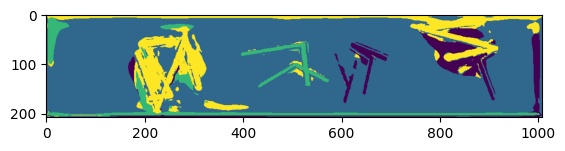

In [24]:
pred_mask_1 = img1_p.squeeze(0) # remove batch dimension
pred_mask_1 = pred_mask_1.argmax(dim=0)
plt.imshow(pred_mask_1.cpu().numpy())

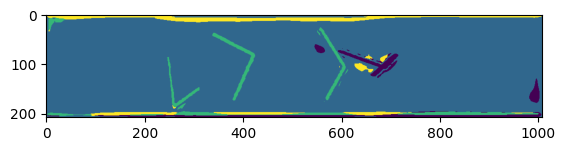

In [25]:
pred_mask_2 = img2_p.squeeze(0) # remove batch dimension
pred_mask_2 = pred_mask_2.argmax(dim=0)
plt.imshow(pred_mask_2.cpu().numpy())

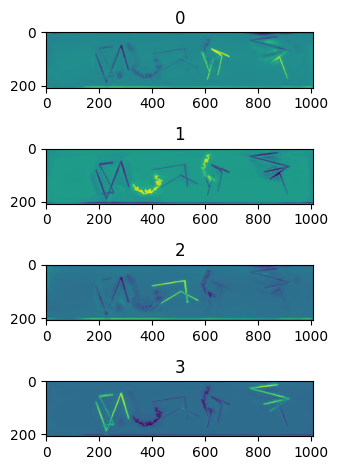

In [26]:
channels_1_0 = {i:img1_p.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels_1_0),1)
for (i,channel), ax in zip(channels_1_0.items(),axes):
    ax.imshow(channel.detach().cpu().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()

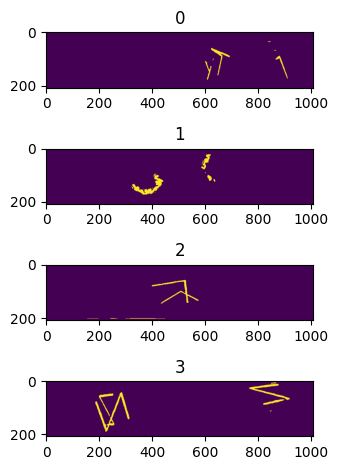

In [27]:
channels_1_0_sm = F.softmax(img1_p.squeeze(),dim=0)

channels_1_0 = {i:channels_1_0_sm.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels_1_0),1)
for (i,channel), ax in zip(channels_1_0.items(),axes):
    
    #c_prob = F.softmax(channel,dim=0)
    
    mask = channel >= 0.8
    
    im = ax.imshow(mask.detach().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()

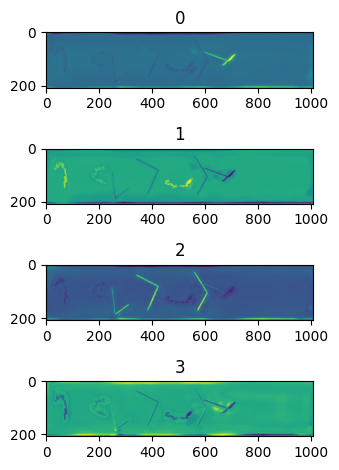

In [28]:
channels_2_0 = {i:img2_p.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels_2_0),1)
for (i,channel), ax in zip(channels_2_0.items(),axes):
    ax.imshow(channel.detach().cpu().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()

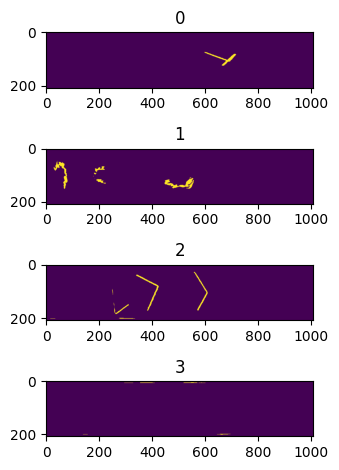

In [29]:
channels_2_0_sm = F.softmax(img2_p.squeeze(),dim=0)

channels_2_0 = {i:channels_2_0_sm.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels_2_0),1)
for (i,channel), ax in zip(channels_2_0.items(),axes):
    
    c_prob = F.softmax(channel,dim=0)
    
    mask = channel >= 0.8
    
    im = ax.imshow(mask.detach().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()

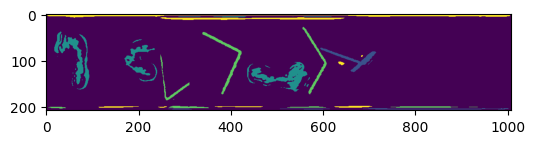

In [30]:
probs = F.softmax(img2_p.squeeze(),dim=0)

max_probs, pred_classes = torch.max(probs, dim=0)

confident_mask = max_probs >= 0.65

confident_pred = torch.where(confident_mask, pred_classes, torch.tensor(-1))

plt.figure(figsize=(6,6))
plt.imshow(confident_pred.cpu().numpy())
plt.show()

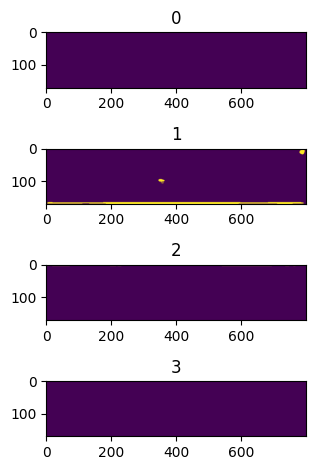

In [31]:
import pickle

with open(r"prediction.pkl","rb") as of:
    result_pickle = pickle.load(of)

channels_p = {i:result_pickle.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels_p),1)
for (i,channel), ax in zip(channels_p.items(),axes):
    
    #c_prob = F.softmax(channel,dim=0)
    
    mask = channel >= 0.8
    
    im = ax.imshow(mask.detach().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()

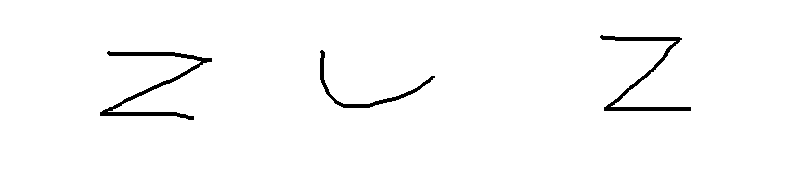

In [32]:
img_p = Image.open("origin.png")
img_p.resize((1008,208))
img_p

In [33]:
img_p = transform(img_p).unsqueeze(0)
img_p = model(img_p)
img_p.shape

torch.Size([1, 4, 170, 800])

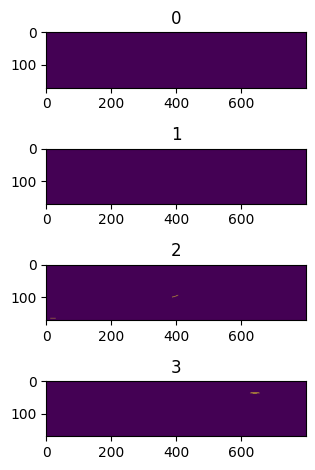

In [34]:
channels = F.softmax(img_p.squeeze(),dim=0)

channels = {i:channels.squeeze()[i,:,:] for i in range(4)}

fig, axes =plt.subplots(len(channels),1)
for (i,channel), ax in zip(channels.items(),axes):
    
    #c_prob = F.softmax(channel,dim=0)
    
    mask = channel >= 0.8
    
    im = ax.imshow(mask.detach().numpy())
    ax.set_title(f"{i}")
plt.tight_layout()
plt.show()